In this Notebook, I tried to predict the Imdb_score values based on the numeric data.
Regression model is tried on multiple regression models with and without feature_selection.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer,StandardScaler
import warnings
warnings.filterwarnings('ignore')

movies = pd.read_csv("../input/movie_metadata.csv")
print (movies.shape)
print (movies.columns)

(5043, 28)
Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')


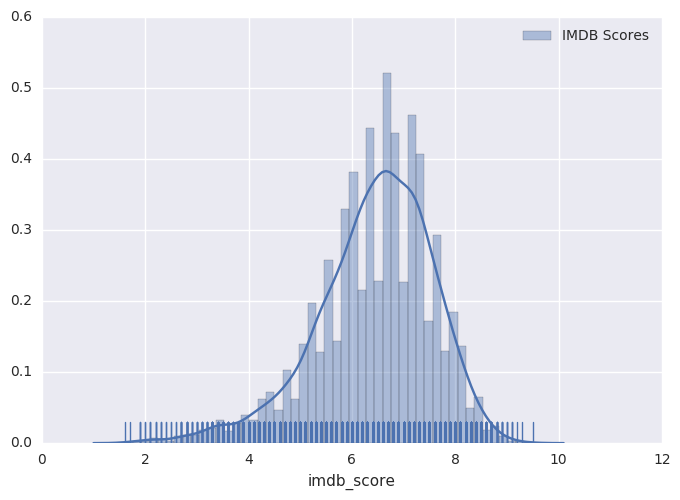

In [2]:
#drop columns which does not seem to have any effect on movie rating

#get numeric data for computation and correlation purposes
numerical_data = movies.select_dtypes(exclude=["object"])

# take out the y value(imdb_score from data)
score_imdb= numerical_data["imdb_score"]
numerical_data = numerical_data.drop(["imdb_score"],axis=1)
year_category = numerical_data["title_year"]
numerical_data = numerical_data.drop(["title_year"],axis=1)
numerical_columns = numerical_data.columns
# print (numerical_columns.shape)
#Plot distribution of actual imdb scores
sns.distplot(score_imdb,rug=True,label="IMDB Scores").legend()

In [3]:
#fill missing values and normalize the data
imp = Imputer(missing_values="NaN",strategy="mean",axis=0)      #default values
numerical_data[numerical_columns] = imp.fit_transform(numerical_data[numerical_columns])
# print (numerical_data.describe())

#Without StandardScaler, SVR with poly kernel will throw error of large size.
#With standard scaling, models has seen improvement in predicting.
#knn model is the most beneficiary of standard scaling
scaler = StandardScaler()
numerical_data[numerical_columns] = scaler.fit_transform(numerical_data[numerical_columns])

# print (numerical_data.describe())
# print (numerical_data.shape)
# numerical_data = pd.DataFrame(numerical_data)
# print (numerical_data.describe())

#get non_numeric informational content
information_data = movies.select_dtypes(include=["object"])
print (information_data.columns)

Index(['color', 'director_name', 'actor_2_name', 'genres', 'actor_1_name',
       'movie_title', 'actor_3_name', 'plot_keywords', 'movie_imdb_link',
       'language', 'country', 'content_rating'],
      dtype='object')


In [4]:
#numpy corrcoef returns symmetric metrics of correlation coef
#Use -from scipy.stats.stats import pearsonr   print pearsonr(a,b)
#check attributes for correlation with movie rating
low_covariance_1 = []
low_covariance_2 = []
low_covariance_15 = []
low_covariance_2g = []
for x in numerical_columns:
    z = (np.corrcoef(numerical_data[x],y=score_imdb))
    if(np.fabs(z[0,1]) < 0.1):
        low_covariance_1.append(x)
    elif(np.fabs(z[0,1]) < 0.15):
        low_covariance_15.append(x)
    elif(np.fabs(z[0,1])<0.2):
        low_covariance_2.append(x)
    else:
        low_covariance_2g.append(x)

print (low_covariance_2g, "\n", low_covariance_2, "\n", low_covariance_15, "\n", low_covariance_1)
#attributes with correlation coef >=0.2 . Thyese attributes will help more than other attributes in regression
#['num_critic_for_reviews', 'duration', 'num_voted_users', 'num_user_for_reviews', 'movie_facebook_likes']

['num_critic_for_reviews', 'duration', 'num_voted_users', 'num_user_for_reviews', 'movie_facebook_likes'] 
 ['director_facebook_likes', 'gross'] 
 [] 
 ['actor_3_facebook_likes', 'actor_1_facebook_likes', 'cast_total_facebook_likes', 'facenumber_in_poster', 'budget', 'actor_2_facebook_likes', 'aspect_ratio']


In [5]:
from sklearn.feature_selection import SelectKBest,SelectPercentile,RFE,RFECV,SelectFromModel
from sklearn.svm import SVR,SVC
from sklearn.linear_model import Lasso
#data which has high correlation with imdb_score is selected
select_k = SelectKBest(k=8)
x_transformed = select_k.fit_transform(numerical_data,y=score_imdb) #x_transformed is numpy array not pandas
#sklearn returns numpy array not pandas object
print (x_transformed.shape)
# print (x_transformed.columns)
#print (x_transformed[0,:])
# print (numerical_data.head(1))

(5043, 8)


In [6]:
from sklearn.svm import LinearSVR

#print("before model selection")
#The underlying estimator SVR has no `coef_` or `feature_importances_` attribute.
#  Either pass a fitted estimator to SelectFromModel or call fit before calling transform.
estimator = LinearSVR().fit(numerical_data,score_imdb)
select_model = SelectFromModel(estimator,prefit=True)
#Uncomment this if you want to use selectFromModel with LinearSVR as feature selection algorithm
x_transformed = select_model.transform(numerical_data)
print (x_transformed.shape)
#print("after model selection")

(5043, 4)


In [7]:
#RFE use recursive selecting of attributes which is a time counsuming process.
estimator = LinearSVR()
selector = RFE(estimator)
selector = selector.fit(numerical_data,score_imdb)
print (selector.support_)
print (selector.ranking_)
#Comment/Uncomment this if you want to use/not use RFE as feature selection algorithm
#x_transformed = selector.transform(numerical_data)
print (x_transformed.shape)

[False  True False  True  True  True  True  True False False False  True
 False False]
[6 1 7 1 1 1 1 1 5 3 4 1 2 8]
(5043, 4)


In [8]:
#some global variables to compare and select best of all methods
best_on_training_data = {"training_score":-10000,"test_score":0,"model":""}
best_on_test_data = {"training_score":-10000,"test_score":0,"model":""}

In [9]:
#generic utility methods
#method to get score as mean deviation
def svm_score(test_y, predict_y):
    # convert to numpy array to compare both predict and actual array
    # Iris_test_y contain indexes from dataframe(parent)
    iris_test_y = np.array(test_y)
    diff = 0
    total_size = test_y.shape[0]
    # print (total_size,test_y.iloc[0],predict_y[0])
    for idx in range(total_size):
        diff += np.fabs(test_y.iloc[idx]-predict_y[idx])
    return diff/total_size
def split_data(x_data,y_data,size=0.1):
    return train_test_split(x_data,y_data,test_size=0.1)

def fit_model(model_to_print,model,training_x,test_x,training_Y,test_y,clr):
    model.fit(X=training_x,y=training_Y)
    predicted_y = model.predict(test_x)
    training_score = model.score(training_x,training_Y)
    test_score = model.score(test_x,test_y)
    if(training_score > best_on_training_data["training_score"]):
        best_on_training_data["training_score"] = training_score
        best_on_training_data["test_score"] = test_score
        best_on_training_data["model"] = model_to_print
    if(training_score > best_on_test_data["test_score"]):
        best_on_test_data["training_score"] = training_score
        best_on_test_data["test_score"] = test_score
        best_on_test_data["model"] = model_to_print
    sns.distplot(predicted_y,hist=True,rug=True,color=clr,label=model_to_print).legend()
    print  (model_to_print,"Score on training data: ",training_score)
    print  (model_to_print,"Score on test data: ",test_score, "\n")
    # print (model_to_print,"training",svm_score(training_Y,model.predict(training_x)))
    # print (model_to_print,svm_score(test_y,predicted_y))

SVR rbf:  Score on training data:  0.413906809072
SVR rbf:  Score on test data:  0.367902251671 

SVR linear:  Score on training data:  0.21674268822
SVR linear:  Score on test data:  0.208321825562 

SVR poly:  Score on training data:  0.188358872248
SVR poly:  Score on test data:  -0.270341940678 



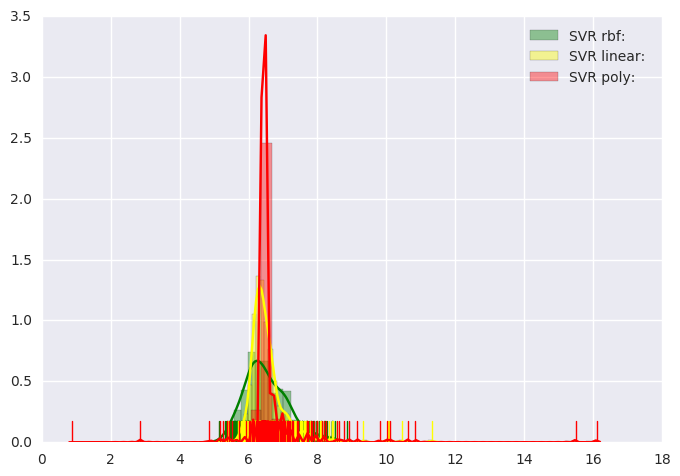

transformed , svr rbf:  Score on training data:  0.234030793443
transformed , svr rbf:  Score on test data:  0.180819131698 

transformed , svr linear:  Score on training data:  0.175933633111
transformed , svr linear:  Score on test data:  0.11981660133 

transformed , svr poly:  Score on training data:  0.0397179687636
transformed , svr poly:  Score on test data:  -964.045970483 



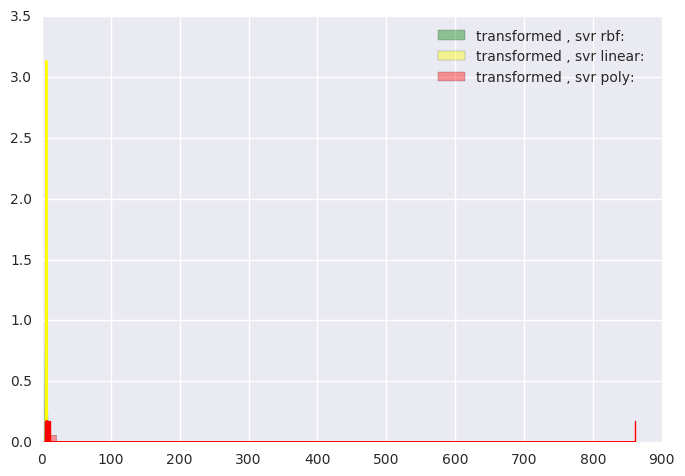

In [10]:
#Fit a regression model on numeric data
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
#On complete data without feature extraction
svr_model = SVR(kernel='rbf') #default
#below kernel is taking infinite time. Hence usign LinearSVR explicitly
#svr_linear_model = SVR(kernel="linear") #infinite time(hanging)
svr_linear_model = LinearSVR()
svr_poly_model = SVR(kernel="poly") #default degree is 3

#Split data beofrehand so that they can be compared on same data
training_x,test_x,training_Y,test_y = split_data(numerical_data,score_imdb)

# plt.plot(score_imdb,label="original data")
fit_model("SVR rbf: ",svr_model,training_x,test_x,training_Y,test_y,"green")
fit_model("SVR linear: ",svr_linear_model,training_x,test_x,training_Y,test_y,"yellow")
#ValueError: Input contains NaN, infinity or a value too large for dtype('float64'). 
#Without Standard Scaler poly kernel will throw above error.
fit_model("SVR poly: ",svr_poly_model,training_x,test_x,training_Y,test_y,"red")
sns.plt.show()

#Calling fit on any scikit-learn estimator will forget all the previously seen data
#So we can use same models for transformed data also
#same model on transformed data with data selection

training_x,test_x,training_Y,test_y = split_data(x_transformed,score_imdb)

fit_model("transformed , svr rbf: ",svr_model,training_x,test_x,training_Y,test_y,"green")
fit_model("transformed , svr linear: ",svr_linear_model,training_x,test_x,training_Y,test_y,"yellow")
fit_model("transformed , svr poly: ",svr_poly_model,training_x,test_x,training_Y,test_y,"red")
sns.plt.show()

knn with k=5:  Score on training data:  0.521186429232
knn with k=5:  Score on test data:  0.248009065498 

knn with k=10:  Score on training data:  0.439900715928
knn with k=10:  Score on test data:  0.283776931308 

knn with k=20:  Score on training data:  0.386387823323
knn with k=20:  Score on test data:  0.298418474145 



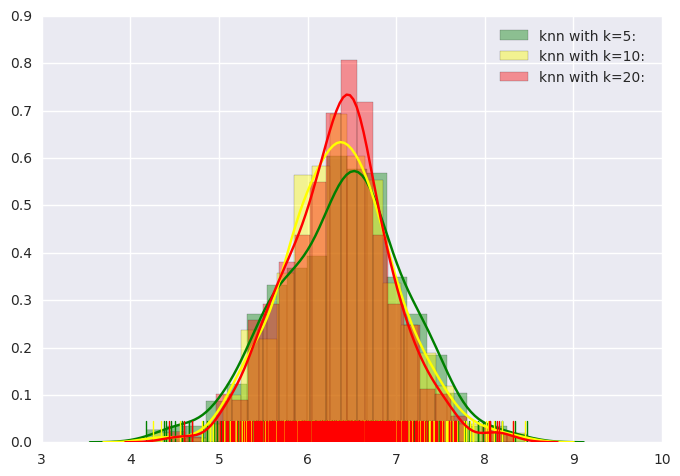

NameError: name 'default_knntraining_x' is not defined

In [11]:
#using knn regression
from sklearn.neighbors import KNeighborsRegressor

default_knn = KNeighborsRegressor(n_neighbors=5)
knn_10 = KNeighborsRegressor(n_neighbors=10)
knn_20 = KNeighborsRegressor(n_neighbors=20)

#Split data beofrehand so that they can be compared on same data
training_x,test_x,training_Y,test_y = split_data(numerical_data,score_imdb)

fit_model("knn with k=5: ",default_knn,training_x,test_x,training_Y,test_y,"green")
fit_model("knn with k=10: ",knn_10,training_x,test_x,training_Y,test_y,"yellow")
fit_model("knn with k=20: ",knn_20,training_x,test_x,training_Y,test_y,"red")
sns.plt.show()
#Calling fit on any scikit-learn estimator will forget all the previously seen data
#So we can use same models for transformed data also
#same model on transformed data with data selection

training_x,test_x,training_Y,test_y = split_data(x_transformed,score_imdb)

fit_model("transformed , knn with k=5: ",default_knntraining_x,test_x,training_Y,test_y,"yellow")
fit_model("transformed , knn with k=10: ",knn_10,training_x,test_x,training_Y,test_y,"red")
fit_model("transformed , knn with k=20: ",knn_20,training_x,test_x,training_Y,test_y,"green")
sns.plt.show()

linear regression:  Score on training data:  0.233749617876
linear regression:  Score on test data:  0.213525760875 

linear regression transformed:  Score on training data:  0.179640963421
linear regression transformed:  Score on test data:  0.176573417509 



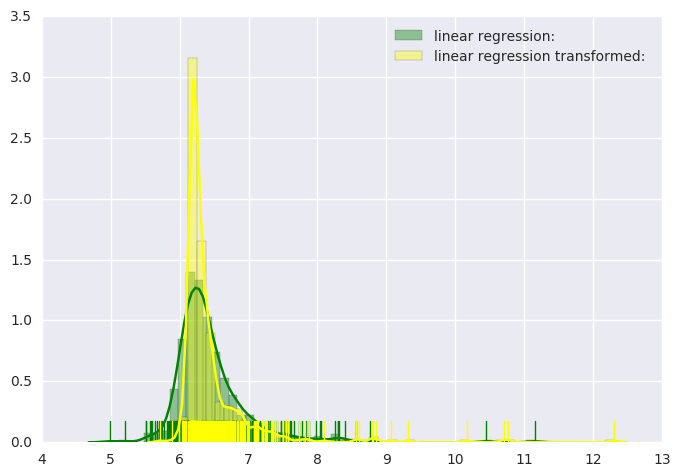

Ridge alpha =1: Score on training data:  0.232363966779
Ridge alpha =1: Score on test data:  0.214305411097 

Ridge alpha =0.5 : Score on training data:  0.232415207534
Ridge alpha =0.5 : Score on test data:  0.214220107241 

Ridge alpha =0.25: Score on training data:  0.232429784905
Ridge alpha =0.25: Score on test data:  0.214151929686 



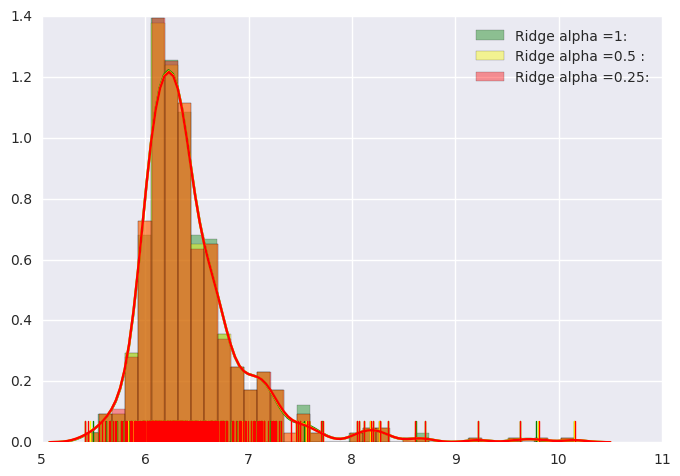

Ridge transformed alpha =1: Score on training data:  0.179139884938
Ridge transformed alpha =1: Score on test data:  0.174889984712 

Ridge transformed alpha =0.5 : Score on training data:  0.179143614378
Ridge transformed alpha =0.5 : Score on test data:  0.174928337927 

Ridge transformed alpha =0.25: Score on training data:  0.179144571951
Ridge transformed alpha =0.25: Score on test data:  0.174947332123 



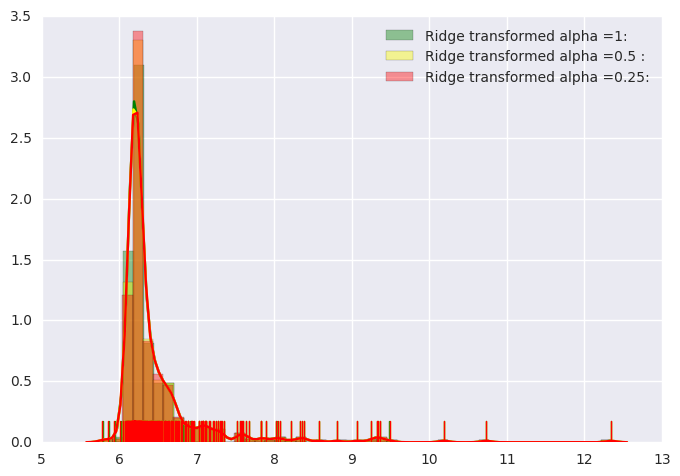

In [12]:
#Other regression models

from sklearn.linear_model import LinearRegression,Ridge

linear_reg = LinearRegression()

#Split data beofrehand so that they can be compared on same data
training_x,test_x,training_Y,test_y = split_data(numerical_data,score_imdb)
fit_model("linear regression: ",linear_reg,training_x,test_x,training_Y,test_y,"green")

#Calling fit on any scikit-learn estimator will forget all the previously seen data
#So we can use same models for transformed data also
training_x,test_x,training_Y,test_y = split_data(x_transformed,score_imdb)

fit_model("linear regression transformed: ",linear_reg,training_x,test_x,training_Y,test_y,"yellow")
sns.plt.show()

#Ridge regression addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of coefficients.
#alpha is the rete of penalty
ridge_1 = Ridge(alpha=1.0)
ridget_point_5 = Ridge(alpha=0.5)
ridget_point_25 = Ridge(alpha=0.25)

#Split data beofrehand so that they can be compared on same data
training_x,test_x,training_Y,test_y = split_data(numerical_data,score_imdb)

fit_model("Ridge alpha =1:",ridge_1,training_x,test_x,training_Y,test_y,"green")
fit_model("Ridge alpha =0.5 :",ridget_point_5,training_x,test_x,training_Y,test_y,"yellow")
fit_model("Ridge alpha =0.25:",ridget_point_25,training_x,test_x,training_Y,test_y,"red")
sns.plt.show()
#Calling fit on any scikit-learn estimator will forget all the previously seen data
#So we can use same models for transformed data also
training_x,test_x,training_Y,test_y = split_data(x_transformed,score_imdb)
fit_model("Ridge transformed alpha =1:",ridge_1,training_x,test_x,training_Y,test_y,"green")
fit_model("Ridge transformed alpha =0.5 :",ridget_point_5,training_x,test_x,training_Y,test_y,"yellow")
fit_model("Ridge transformed alpha =0.25:",ridget_point_25,training_x,test_x,training_Y,test_y,"red")
sns.plt.show()
#By plotting the distribution against predicted values. You can see that values are in the middle range(5,7) and have a peak at 6.
#While the original distribution is more randomly distributed.
#Values of score returns the mean deviation from actual score.

In [13]:
#Let's check best models on trainging data
print ("best model on trainging score is :")
print ("training_score: ", best_on_training_data["training_score"])
print ("test_score:", best_on_training_data["test_score"])
print ("model: ", best_on_training_data["model"])


print ("\n\n\nbest model on test score is :")
print ("training_score: ", best_on_test_data["training_score"])
print ("test_score:", best_on_test_data["test_score"])
print ("model: ", best_on_test_data["model"])

best model on trainging score is :
training_score:  0.521186429232
test_score: 0.248009065498
model:  knn with k=5: 



best model on test score is :
training_score:  0.386387823323
test_score: 0.298418474145
model:  knn with k=20: 


SVR rbf:  Score on training data:  0.407373263133
SVR rbf:  Score on test data:  0.423291457949 

knn with k=5:  Score on training data:  0.510955240096
knn with k=5:  Score on test data:  0.356333098957 

linear regression:  Score on training data:  0.226665213821
linear regression:  Score on test data:  0.279129421798 

Ridge alpha =1: Score on training data:  0.226602688465
Ridge alpha =1: Score on test data:  0.278755305184 



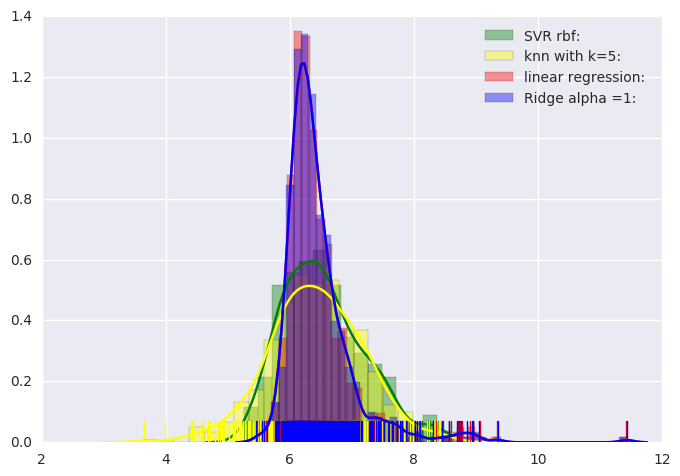

transformed , svr rbf:  Score on training data:  0.229092570632
transformed , svr rbf:  Score on test data:  0.198583820263 

transformed , knn with k=5:  Score on training data:  0.409160033892
transformed , knn with k=5:  Score on test data:  0.149297119616 

linear regression transformed:  Score on training data:  0.176752157508
linear regression transformed:  Score on test data:  0.20203899204 

Ridge transformed alpha =1: Score on training data:  0.176747425355
Ridge transformed alpha =1: Score on test data:  0.20183451537 



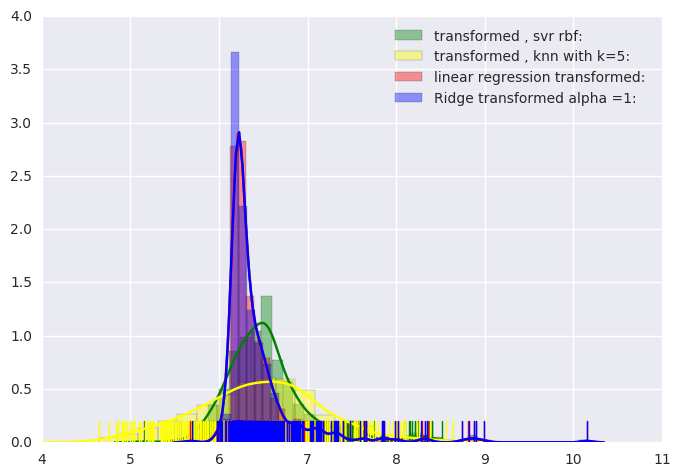

In [14]:
#Lets comprare the distribution of above types.

#Calling fit on any scikit-learn estimator will forget all the previously seen data
#So we can use same models for transformed data also

#Split data beofrehand so that they can be compared on same data
training_x,test_x,training_Y,test_y = split_data(numerical_data,score_imdb)

fit_model("SVR rbf: ",svr_model,training_x,test_x,training_Y,test_y,"green")
fit_model("knn with k=5: ",default_knn,training_x,test_x,training_Y,test_y,"yellow")
fit_model("linear regression: ",linear_reg,training_x,test_x,training_Y,test_y,"red")
fit_model("Ridge alpha =1:",ridge_1,training_x,test_x,training_Y,test_y,"blue")
sns.plt.show()

training_x,test_x,training_Y,test_y = split_data(x_transformed,score_imdb)

fit_model("transformed , svr rbf: ",svr_model,training_x,test_x,training_Y,test_y,"green")
fit_model("transformed , knn with k=5: ",default_knn,training_x,test_x,training_Y,test_y,"yellow")
fit_model("linear regression transformed: ",linear_reg,training_x,test_x,training_Y,test_y,"red")
fit_model("Ridge transformed alpha =1:",ridge_1,training_x,test_x,training_Y,test_y,"blue")
sns.plt.show()

SVR rbf:  Score on training data:  0.409330199354
SVR rbf:  Score on test data:  0.386813560221 

transformed , svr rbf:  Score on training data:  0.232528881834
transformed , svr rbf:  Score on test data:  0.187760549594 



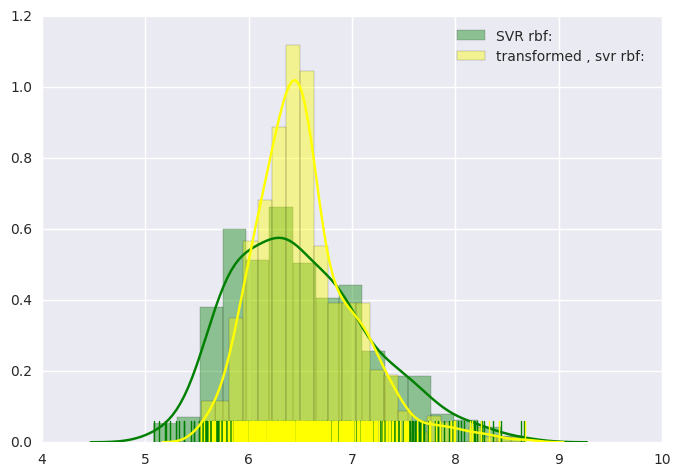

knn with k=5:  Score on training data:  0.519948801552
knn with k=5:  Score on test data:  0.285368371917 

transformed , knn with k=5:  Score on training data:  0.416256925807
transformed , knn with k=5:  Score on test data:  0.0851972884369 



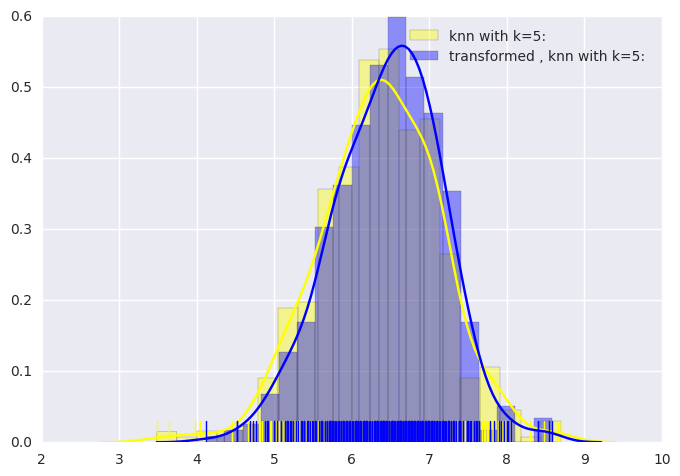

linear regression:  Score on training data:  0.22832127924
linear regression:  Score on test data:  0.263180991366 

linear regression transformed:  Score on training data:  0.181491013408
linear regression transformed:  Score on test data:  0.160206301703 



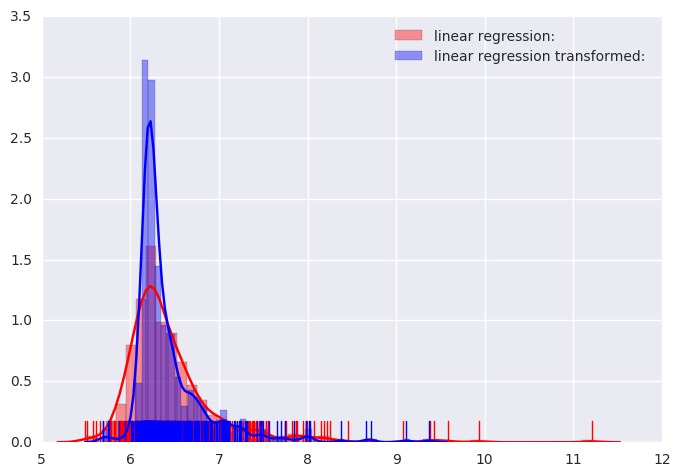

Ridge alpha =1: Score on training data:  0.228265746397
Ridge alpha =1: Score on test data:  0.262214988797 

Ridge transformed alpha =1: Score on training data:  0.181485731511
Ridge transformed alpha =1: Score on test data:  0.160109268845 



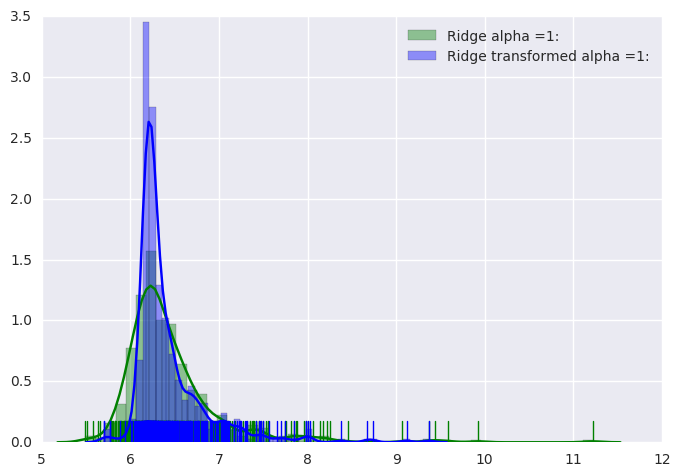

In [15]:
#Lets comprare the distribution same type on transformed and untransformed data

#Calling fit on any scikit-learn estimator will forget all the previously seen data
#So we can use same models for transformed data also

#Split data beofrehand so that they can be compared on same data
training_x,test_x,training_Y,test_y = split_data(numerical_data,score_imdb)
training_x_t,test_x_t,training_Y_t,test_y_t = split_data(x_transformed,score_imdb)

fit_model("SVR rbf: ",svr_model,training_x,test_x,training_Y,test_y,"green")
fit_model("transformed , svr rbf: ",svr_model,training_x_t,test_x_t,training_Y_t,test_y_t,"yellow")
sns.plt.show()
fit_model("knn with k=5: ",default_knn,training_x,test_x,training_Y,test_y,"yellow")
fit_model("transformed , knn with k=5: ",default_knn,training_x_t,test_x_t,training_Y_t,test_y_t,"blue")
sns.plt.show()
fit_model("linear regression: ",linear_reg,training_x,test_x,training_Y,test_y,"red")
fit_model("linear regression transformed: ",linear_reg,training_x_t,test_x_t,training_Y_t,test_y_t,"blue")
sns.plt.show()
fit_model("Ridge alpha =1:",ridge_1,training_x,test_x,training_Y,test_y,"green")
fit_model("Ridge transformed alpha =1:",ridge_1,training_x_t,test_x_t,training_Y_t,test_y_t,"blue")
sns.plt.show()

**Conclusion** :-

 - KNN scores better than SVM, linear regression and ridge.  Linear Regression and Ridge scores least among all. 
 - Standard scaling of data increases the score on average. Most of time, increasing the value o K in KNN increases the score. 
 - Still, Accuracy of system is very low. Mean deviation of test data from original data is in the range [0.5,0.9].
 - IMDB_Score predicted by the model are concentrated in the mid region of score. Most scores are in the range [5,7] with peak around 6.
 - Most models doesn't predict any value less than 5 and more than 7. 
 - Features selected using SelectFromModel and RFE feature selection algorithms performs better than feature selected from SelectKBest.